# Comparando estratégias

- Amostra por incerteza
- Amostragem aleatória
- Consulta por comitê
- Aprendizado passivo
- Redução do erro esperado

In [1]:
import numpy as np
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
# Plots
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
from copy import deepcopy

## Classificadores

### Algoritmos

In [4]:
from sklearn.neighbors import KNeighborsClassifier

### Conjunto de dados

In [17]:
from sklearn.datasets import load_iris, load_digits, load_wine, load_breast_cancer

## Amostra por incerteza

In [6]:
def uncertain_sample(X_raw, y_raw, n_queries):
    from modAL.uncertainty import classifier_uncertainty
    from modAL.models import ActiveLearner
    
    
    knn = KNeighborsClassifier(k)
    perfomance_history = []

    initial_idx = np.random.choice(range(len(X_raw)), size=k+1, replace=False)
    X_train, y_train = X_raw[initial_idx], y_raw[initial_idx]

    # initialize the learner
    learner = ActiveLearner(
        estimator=knn,
        X_training=X_train, y_training=y_train
    )
    unqueried_score = learner.score(X_raw, y_raw)

    perfomance_history.append(unqueried_score)

    total_of_samples = 0
    #while learner.score(X_raw, y_raw) < 0.90:
    while (total_of_samples != n_queries - 1):
        stream_idx = np.random.choice(range(len(X_raw)))
        #print(stream_idx)
        #print(X_raw[stream_idx].reshape(1, -1))
        #print(classifier_uncertainty(learner, X_raw[stream_idx].reshape(1, -1)))
        #print("----------------------")
        if classifier_uncertainty(learner, X_raw[stream_idx].reshape(1, -1)) > 0:
            learner.teach(X_raw[stream_idx].reshape(1, -1), y_raw[stream_idx].reshape(-1, ))
            new_score = learner.score(X_raw, y_raw)
            perfomance_history.append(new_score)
            total_of_samples = total_of_samples + 1

    performance_history_total.append(perfomance_history)
    legend.append("Uncertainty Sampling")

## Amostragem aleatória

In [7]:
def random_sampling(X_raw, y_raw, n_queries):
    performance_history = []
    size_of_dataset = X_raw.shape[0]
    
    for i in range(1,n_queries+1):

        training_indices = np.random.randint(low=0, high=size_of_dataset, size=k+i)

        X_train = X_raw[training_indices]
        y_train = y_raw[training_indices]

        X_test = np.delete(X_raw, training_indices, axis=0)
        y_test = np.delete(y_raw, training_indices, axis=0)

        knn = KNeighborsClassifier(k)
        knn.fit(X_train, y_train)
        pred = knn.predict(X_test)
        performance_history.append(knn.score(X_test,y_test))

    performance_history_total.append(performance_history)
    legend.append("Random Sampling")

## Consulta por comitê

In [8]:
from modAL.models import ActiveLearner, Committee

def query_by_committee(X_raw,y_raw,n_queries):

    performance_history = []
    for i in range(1,n_queries+1):

        learner_list = []
        X_pool = deepcopy(X_raw)
        y_pool = deepcopy(y_raw)

        train_idx = np.random.choice(range(X_pool.shape[0]), size=k+i, replace=False)
        X_train = X_pool[train_idx]
        y_train = y_pool[train_idx]

        # creating a reduced copy of the data with the known instances removed
        X_pool = np.delete(X_pool, train_idx, axis=0)
        y_pool = np.delete(y_pool, train_idx)

        # initializing learner
        learner = ActiveLearner(
            estimator=KNeighborsClassifier(k),
            X_training=X_train, y_training=y_train
        )
        learner_list.append(learner)

        # assembling the committee
        committee = Committee(learner_list=learner_list)

        # query by committee
        for idx in range(n_queries):
            query_idx, query_instance = committee.query(X_pool)
            committee.teach(
                X=X_pool[query_idx].reshape(1, -1),
                y=y_pool[query_idx].reshape(1, )
            )

            # remove queried instance from pool
            X_pool = np.delete(X_pool, query_idx, axis=0)
            y_pool = np.delete(y_pool, query_idx)
        performance_history.append(committee.score(X_raw, y_raw))
    performance_history_total.append(performance_history)
    legend.append("Query by committee")

## Aprendizado passivo

In [9]:
def passive_learning(X_raw, y_raw, n_queries):
    from sklearn.model_selection import train_test_split

    X_train, X_test, Y_train, Y_test = train_test_split(X_raw, y_raw,test_size=0.3,random_state=1)
    knn = KNeighborsClassifier(k)
    knn.fit(X_train, Y_train)

    from sklearn.model_selection import cross_val_score
    
    scores = cross_val_score(knn, X_raw, y_raw, cv=n_queries, scoring='accuracy')
    performance_history_total.append(scores)
    legend.append("Passive learning")

## Amostragem baseada na reserva de exemplos

In [10]:
def pool_based_sampling(X_raw, y_raw, n_queries):
    X_raw = deepcopy(X_raw)
    y_raw = deepcopy(y_raw)

    # Isolate our examples for our labeled dataset.
    n_labeled_examples = X_raw.shape[0]
    training_indices = np.random.randint(low=0, high=n_labeled_examples, size=k)

    X_train = X_raw[training_indices]
    y_train = y_raw[training_indices]

    # Isolate the non-training examples we'll be querying.
    X_pool = np.delete(X_raw, training_indices, axis=0)
    y_pool = np.delete(y_raw, training_indices, axis=0)
    
    
    # Specify our core estimator along with it's active learning model.
    knn = KNeighborsClassifier(n_neighbors=k)
    learner = ActiveLearner(estimator=knn, X_training=X_train, y_training=y_train)
    
    unqueried_score = learner.score(X_raw, y_raw)

    performance_history = [unqueried_score]

    # Allow our model to query our unlabeled dataset for the most
    # informative points according to our query strategy (uncertainty sampling).
    for index in range(n_queries):
      query_index, query_instance = learner.query(X_pool)

      # Teach our ActiveLearner model the record it has requested.
      X, y = X_pool[query_index].reshape(1, -1), y_pool[query_index].reshape(1, )
      learner.teach(X=X, y=y)

      # Remove the queried instance from the unlabeled pool.
      X_pool, y_pool = np.delete(X_pool, query_index, axis=0), np.delete(y_pool, query_index)

      # Calculate and report our model's accuracy.
      model_accuracy = learner.score(X_raw, y_raw)

      # Save our model's performance for plotting.
      performance_history.append(model_accuracy)
    print("\n")
    
    predictions = learner.predict(X_raw)    
    performance_history_total.append(performance_history)
    legend.append("Pool-based Sampling")

## Visualizando as estratégias

In [11]:
def plot_strategies_acc(performance_history_total, legend, title):
    fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

    for idx,pht in enumerate(performance_history_total):
        ax.plot(pht)
        ax.scatter(range(len(pht)), pht, s=13)

    ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
    ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
    ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

    ax.set_ylim(bottom=0, top=1)
    ax.grid(True)

    ax.set_title(title + " - Classification accuracy with {n_queries} queries".format(n_queries = n_queries))
    ax.set_xlabel('Query iteration')
    ax.set_ylabel('Classification Accuracy')
    ax.legend(legend, loc='lower right')

    plt.show()

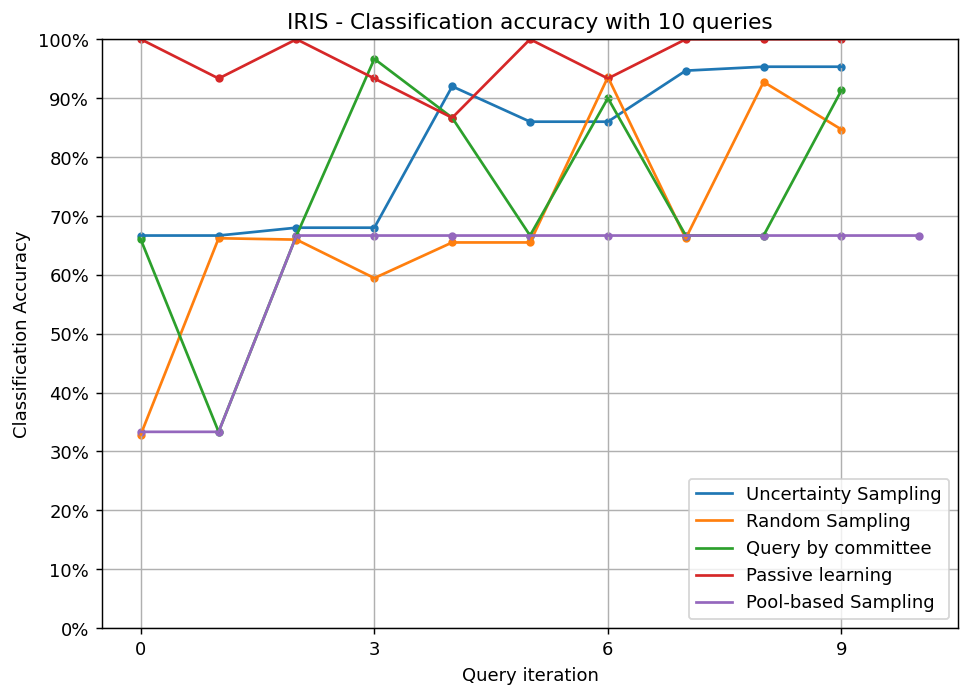

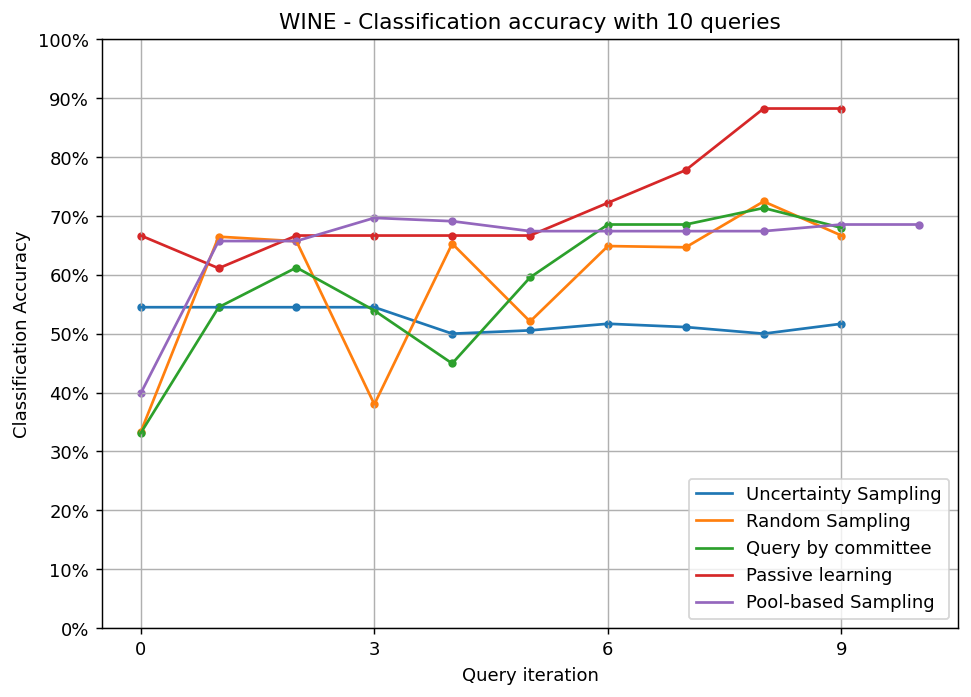

In [13]:
n_queries = 10
k = 3

#title = ["IRIS", "DIGITS", "WINE", "BREAST CANCER"]
title = ["IRIS", "WINE"]
#datasets = [load_iris(), load_digits(), load_wine(), load_breast_cancer()]
datasets = [load_iris(), load_wine()]

for idx,dataset in enumerate(datasets): 
    data = dataset
    X_raw = data['data']
    y_raw = data['target']
    legend = []
    performance_history_total = []

    uncertain_sample(deepcopy(X_raw), deepcopy(y_raw), n_queries)
    random_sampling(deepcopy(X_raw), deepcopy(y_raw), n_queries)
    query_by_committee(deepcopy(X_raw),deepcopy(y_raw),n_queries)
    passive_learning(deepcopy(X_raw), deepcopy(y_raw), n_queries)
    pool_based_sampling(deepcopy(X_raw), deepcopy(y_raw), n_queries)
    plot_strategies_acc(performance_history_total, legend, title[idx])

In [14]:
data = load_breast_cancer()
X_raw = data['data']
y_raw = data['target']

from modAL.expected_error import expected_error_reduction
from modAL.models import ActiveLearner

knn = KNeighborsClassifier(k)
perfomance_history = []

initial_idx = np.random.choice(range(len(X_raw)), size=k+1, replace=False)
X_train, y_train = X_raw[initial_idx], y_raw[initial_idx]

learner = ActiveLearner(
    estimator=knn,
    X_training=X_train, y_training=y_train
)
unqueried_score = learner.score(X_raw, y_raw)

perfomance_history.append(unqueried_score)

total_of_samples = 0
#while learner.score(X_raw, y_raw) < 0.90:
while (total_of_samples != n_queries - 1):
    stream_idx = np.random.choice(range(len(X_raw)))
    #print(stream_idx)
    #print(X_raw[stream_idx].reshape(1, -1))
    print(expected_error_reduction(learner, X_raw[stream_idx].reshape(1, -1)))
    #print("----------------------")
    if expected_error_reduction(learner, X_raw[stream_idx].reshape(1, -1)) > 0:
        learner.teach(X_raw[stream_idx].reshape(1, -1), y_raw[stream_idx].reshape(-1, ))
        new_score = learner.score(X_raw, y_raw)
        perfomance_history.append(new_score)
        total_of_samples = total_of_samples + 1

ValueError: Found array with 0 sample(s) (shape=(0, 30)) while a minimum of 1 is required.